## Семинар 2. Линейные методы классификации и регресии: метод стохастического градиента

**Библиотеки**

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm  # Для отрисовки прогресса обучения

from scipy.special import expit
import numpy as np
import torch  # Будем использовать для подсчета градиента произвольной функции

from sklearn.linear_model import (LogisticRegression,
                                  LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold

**1. Оптимизационные задачи**

Задачи машинного обучения всегда сводятся к решению некоторой задачи оптимизации:  
<center>$\mathbf{\hat{w}}=arg\min_{w\in\mathcal{W}}{Q(\mathbf{w},X,y)}$</center>  

Обычно данные задачи оптимизации решают двумя способами:  
1. Аналитическое решение;
2. Численные методы (в том числе градиентный спуск).  

Аналитическое решение имеет самый большой недостаток в том, что не для любого $Q$ оно существует, или может быть выписано аналитически. В стохастическом градиентном спуске есть ряд ограничений, которые нужно удовлетворить, чтобы была сходимость.

**Аналитическое решение для задачи линейной регрессии**

Линейная модель регрессии:  
<center>$\mathfrak{F}_{rg}=\{f(\mathbf{w}, \mathbf{x}) = \mathbf{w}^T\mathbf{x} | \mathbf{w} \in \mathbb{R}^n\}$</center>  

Требуется решить следующую оптимизационную задачу:
<center>$\hat{\theta}=\arg\min_{\mathbf{w}\in\mathbb{R}^n}\dfrac{1}{l}\sum_{i=1}^{l}{(\mathbf{w}^T\mathbf{x_i}-y_i)^2}$</center>  

Для удобства перепишем в матричном виде:
<center>$\sum_{i=1}^{l}{(\mathbf{w}^T\mathbf{x_i}-y_i)^2}=(\mathbf{X}\mathbf{w}-\mathbf{y})^T(\mathbf{X}\mathbf{w}-\mathbf{y})=\mathbf{w}^T\mathbf{X}^T\mathbf{X}\mathbf{w}-2\mathbf{y}\mathbf{X}\mathbf{w}+\mathbf{y}^T\mathbf{y}$</center>  

Заметим, что наша задача является выпуклой, то есть существует единственный экстремум - глобальный минимум, для его нахождения воспользуемся необходимым условием первого порядка:  
<center>$\dfrac{\partial}{\partial\mathbf{w}}(\mathbf{w}^T\mathbf{X}^T\mathbf{X}\mathbf{w}-2\mathbf{y}\mathbf{X}\mathbf{w}+\mathbf{y}^T\mathbf{y})=0=2\mathbf{X}^T\mathbf{X}\mathbf{w}-2\mathbf{X}^T\mathbf{y}$</center>  
.  
<center>$\hat{\mathbf{w}}=(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$</center>  

Таким образом, было получено аналитическое решение задачи линейной регрессии.

**Пример линейной регрессии**

In [33]:
np.random.seed(0)
l = 40

# Генерация данных
x = np.linspace(0, 30, num=l)
Y = x + 4*np.sin(x) + 3*np.random.randn(l)

# Генерация признаков
X = np.vstack([np.ones_like(x), x, np.sin(x)]).T

# Решение задачи регрессии
w = np.linalg.inv(X.T@X)@X.T@Y

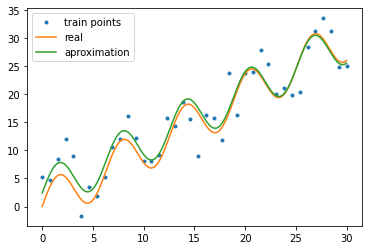

In [34]:
plt.plot(x, Y, '.', label='train points')

x_plot = np.linspace(0, 30, num=10000)
plt.plot(x_plot, 4*np.sin(x_plot) + x_plot, label='real')

X_plot = np.vstack([np.ones_like(x_plot), x_plot, np.sin(x_plot)]).T
plt.plot(x_plot, X_plot@w, label='aproximation')

plt.legend(loc='best')
plt.show()

**Оптимизационная задача для задачи линейной классификации**

Линейная модель бинарной $\{-1, 1\}$ классификации:  
<center>$\mathfrak{F}_{blc}=\{f(\mathbf{w},\mathbf{x}) = sign(\mathbf{w}^T\mathbf{x}) | \mathbf{w} \in \mathbb{R}^n\}$</center>  

Требуется решить следующую оптимизационную задачу:  
<center>$\mathbf{\hat{w}}=\arg\min_{\mathbf{w}\in\mathbb{R}^n}\dfrac{1}{l}\sum_{i=1}^{l}{[\mathbf{w}^T\mathbf{x_i}\neq y_i]=\arg\min_{\mathbf{w}\in\mathbb{R}^n}}\dfrac{1}{l}\sum_{i=1}^{l}[y_i\mathbf{w}^T\mathbf{x_i}<0]$</center>  

Но вместо этой задачи оптимизации будем минимизировать верхнюю оценку:  
<center>$\mathbf{\hat{w}}=\arg\min_{\mathbf{w}\in\mathbb{R}^n}\dfrac{1}{l}\sum_{i=1}^{l}{log_2(1+e^{-y_i\mathbf{w}^T\mathbf{x_i}})}$</center>  

В данном случае аналитическое решение найти не получится. Будем минимизировать градиентными методами.

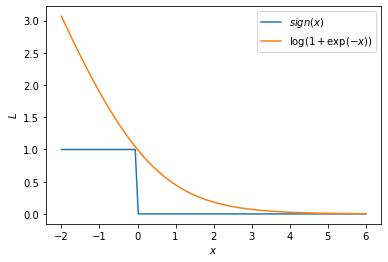

In [36]:
def sign(x):
    return np.array(x <= 0, dtype=np.int64)

def upper_bound(x):
    return np.log2(1+np.exp(-x))


x = np.linspace(-2, 6, 100)
plt.plot(x, sign(x), label='$sign(x)$')
plt.plot(x, upper_bound(x), label='$\log(1+\exp(-x))$')

plt.xlabel('$x$')
plt.ylabel('$L$')
plt.legend(loc='best')
plt.show()

**Стохастический градиентный спуск**

Простой градиентный спуск:  
<center>$\mathbf{w}_k+1=\mathbf{w}_k-\alpha_k\nabla Q(\mathbf{w},\mathbf{X},\mathbf{y})$</center>  

Минусы:  
1. Очень долго считать градиент суммы $Q(\mathbf{w},\mathbf{X},\mathbf{y})=\dfrac{1}{l}\sum_{i=1}^{l}{L(\mathbf{w},\mathbf{x}_i,\mathbf{y}_i)}$;  
2. Маленькая скорость сходимости.  

Рассмотрим стохастический грдиентный спуск:
<center>$\mathbf{w}_{k+1}=\mathbf{w}_k-\alpha_k\nabla L(\mathbf{w},\mathbf{X}_{i_k},y_{i_k})$</center>  

В случае, если индекс объекта $i_k$ сгенерирован равновероятно, то справедливо следующее свойство:  
<center>$E\nabla L(\mathbf{w},\mathbf{x}_{i_k},y_{i_k})=\dfrac{1}{l}\sum_{i=1}^{l}{\nabla L(\mathbf{w},\mathbf{x}_i,y_i)=\nabla Q(\mathbf{w},\mathbf{X},\mathbf{y})}$</center>  

Таким образом, получаем, что в среднем градиент на каждой итерации направлен вдоль истинного градиента.

**Анализ сходимости стохастического градиента**

Рассмотим задачу оптимизации:  
<center>$Q(\mathbf{w})=\dfrac{1}{l}\sum_{i=1}^{l}{L(\mathbf{w},i)}\to\min_\mathbf{w}$,</center>

Где $Q$ является выпуклой функцией по параметру $\mathbf{w}$.

Стохастический градиентный спуск:  
<center>$\mathbf{w}_{k+1}=\mathbf{w}_k-\alpha_k\hat{\mathbf{g}}_k, E\hat{\mathbf{g}}_k=\mathbf{g}_k=\nabla Q(\mathbf{w})$,</center>  

где $\hat{\mathbf{g}}_k$ - градиент на $k$-ом шаге на $i$-ом объекте.

Пусть $\mathbf{w}^*$ - истинный минимум функции $Q$. Рассмотрим норму невязки:  
<center>$\|\mathbf{w}_{k+1}-\mathbf{w}^*\|^2=\|\mathbf{w}_k-\mathbf{w}^*-\alpha_k\hat{\mathbf{g}}_k\|^2=\|\mathbf{w}_k-\mathbf{w}^*\|^2-2\alpha_k\hat{\mathbf{g}}_k^T(\mathbf{w}_k-\mathbf{w}^*)+\alpha^2_k\|\hat{\mathbf{g}}_k\|^2$</center>  

Рассмотрим среднее значение невязки при случайном выборе $\hat{\mathbf{g}}_k$:
<center>$E\|\mathbf{w}_{k+1}-\mathbf{w}^*\|^2=\|\mathbf{w}_k-\mathbf{w}^*\|^2-2\alpha_k\mathbf{g}_k^T(\mathbf{w}_k-\mathbf{w}^*)+\alpha_k^2E\|\hat{\mathbf{g}}_k\|$</center>  

Далее нам потребуется следующая величина:
<center>$\alpha_k\mathbf{g}_k^T(\mathbf{w}_k-\mathbf{w}^*)=\dfrac{1}{2}\|\mathbf{w}_k-\mathbf{w}^*\|^2-\dfrac{1}{2}E\|\mathbf{w}_{k+1}-\mathbf{w}^*\|^2+\alpha_k^2E\|\hat{\mathbf{g}}_k\|^2$</center>  

В силу выпуклости функции $Q$ справедливо следующее свойство:  
<center>$Q(\mathbf{w}_k)-Q(\mathbf{w}^*)\leq\mathbf{g}_k^T(\mathbf{w}_k-\mathbf{w}^*), \mathbf{g}_k^T=\nabla Q(\mathbf{w})$</center>  

Откуда следует:  
<center>$\mathbf{\alpha}_k(Q(\mathbf{w}_k)-Q(\mathbf{w}^*))\leq\dfrac{1}{2}\|\mathbf{w}_k-\mathbf{w}^*\|^2-\dfrac{1}{2}E\|\mathbf{w}_{k+1}-\mathbf{w}^*\|^2+\dfrac{\mathbf{\alpha}^2_k}{2}E\|\hat{\mathbf{g}}_k\|^2$</center>  

Далее усредним уже по $\mathbf{g}_k$ для всеъ $k=\overline{1,K}$ и просуммируем $K$ первых итераций:  
<center>$\sum_{k=1}^{K}{\mathbf{\alpha}_k(EQ(\mathbf{w}_k)-Q(\mathbf{w}^*))}\leq\dfrac{1}{2}\|\mathbf{w}_0-\mathbf{w}^*\|^2-\dfrac{1}{2}E\|\mathbf{w}_{k+1}-\mathbf{w}^*\|^2+\sum_{k=1}^{K}{\dfrac{\mathbf{\alpha}_k^2}{2}E\|\hat{\mathbf{g}}_k\|^2}\leq$</center>  
.  
<center>$\leq\dfrac{1}{2}\|\mathbf{w}_0-\mathbf{w}^*\|^2+\sum_{k=1}^{K}{\dfrac{\mathbf{\alpha}_k^2}{2}E\|\hat{\mathbf{g}}_k\|^2}$</center>  

Воспользуемся неравенством Йенсена для выпуклой функции $Q$:  
<center>$EQ(\dfrac{1}{\sum{\mathbf{\alpha}}_k}\sum{\mathbf{\alpha}_k\mathbf{x}_k})-Q(\mathbf{x}^*)\leq\sum_{k=1}^{K}{\mathbf{\alpha}_k(EQ(\mathbf{x}_k)-Q(\mathbf{x}^*))}\leq\dfrac{1}{2}\|\mathbf{x}_0-\mathbf{x}^*\|^2+$</center>  
.  
<center>$+\sum_{k=1}^{K}{\dfrac{\mathbf{\alpha}^2_k}{2}E\|\hat{\mathbf{g}}_k\|^2}$</center>  

Пусть  
<center>$\hat{\mathbf{x}}_K=\dfrac{1}{\sum{\mathbf{\alpha}}_k}\sum{\mathbf{\alpha}_k\mathbf{x}_k}$</center>  
.  

<center>$\|\mathbf{x}_0-\mathbf{x}^*\|^2\leq R^2$</center>  
.  
<center>$E\|\hat{\mathbf{g}}_k\|^2\leq G^2$</center>  

Тогда плоучаем следующую оценку:  
<center>$EQ(\hat{\mathbf{x}}_K)-Q(\mathbf{x}^*)\leq\dfrac{R^2+G^2\sum{\mathbf{\alpha}_k^2}}{2\sum{\mathbf{\alpha}_k}}$</center>

**Анализ оценки на скорость сходимости**